In [ ]:
# @title load

import pandas as pd

df = pd.read_csv('2020-2025.csv', parse_dates=['SALE DATE'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154748 entries, 0 to 154747
Data columns (total 21 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   BOROUGH                         154748 non-null  int64         
 1   NEIGHBORHOOD                    154748 non-null  object        
 2   BUILDING CLASS CATEGORY         154748 non-null  object        
 3   TAX CLASS AT PRESENT            154718 non-null  object        
 4   BLOCK                           154748 non-null  int64         
 5   LOT                             154748 non-null  int64         
 6   EASEMENT                        0 non-null       float64       
 7   BUILDING CLASS AT PRESENT       154718 non-null  object        
 8   ADDRESS                         154748 non-null  object        
 9   APARTMENT NUMBER                23483 non-null   object        
 10  ZIP CODE                        154722 non-null  float64

In [ ]:
# @title clean

df = df.drop(columns=['EASEMENT'])
df['ZIP CODE'] = df['ZIP CODE'].astype('Int64')
df['YEAR BUILT'] = df['YEAR BUILT'].astype('Int64')
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].astype('Int64')

In [ ]:
# @title generic neighborhood processing

def process_neighborhood_data(df, neighborhood_name, min_year_built=None):
    df_filtered = df[(df['NEIGHBORHOOD'] == neighborhood_name) &
                     (df['APARTMENT NUMBER'].notna()) &
                     (df['BUILDING CLASS AT PRESENT'] =='R4') &
                     (df['SALE PRICE'] > 0)].copy()

    df_processed = df_filtered[['ADDRESS',
                                'APARTMENT NUMBER',
                                'ZIP CODE',
                                'YEAR BUILT',
                                'SALE PRICE',
                                'SALE DATE']].copy()

    if min_year_built is not None:
        df_processed = df_processed[df_processed['YEAR BUILT'] >= min_year_built].copy()

    df_processed['housenum'] = df_processed['ADDRESS'].str.split(' ').str[0]
    df_processed['streetname'] = (df_processed['ADDRESS'].str.split(' ').str[1] + ' ' +
                                  df_processed['ADDRESS'].str.split(' ').str[2].str.replace(',', ''))
    df_processed['aptno'] = df_processed['APARTMENT NUMBER']

    df_processed = df_processed.drop(columns=['ADDRESS', 'APARTMENT NUMBER'])

    return df_processed

In [ ]:
# for lic/ast
dflic = process_neighborhood_data(df, 'LONG ISLAND CITY', 2019)
dfast = process_neighborhood_data(df, 'ASTORIA', 2019)

In [ ]:
dflic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 752 entries, 162 to 130537
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ZIP CODE    752 non-null    Int64         
 1   YEAR BUILT  752 non-null    Int64         
 2   SALE PRICE  752 non-null    int64         
 3   SALE DATE   752 non-null    datetime64[ns]
 4   housenum    752 non-null    object        
 5   streetname  752 non-null    object        
 6   aptno       752 non-null    object        
dtypes: Int64(2), datetime64[ns](1), int64(1), object(3)
memory usage: 48.5+ KB


In [ ]:
dfast.info()

<class 'pandas.core.frame.DataFrame'>
Index: 330 entries, 587 to 133302
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ZIP CODE    330 non-null    Int64         
 1   YEAR BUILT  330 non-null    Int64         
 2   SALE PRICE  330 non-null    int64         
 3   SALE DATE   330 non-null    datetime64[ns]
 4   housenum    330 non-null    object        
 5   streetname  330 non-null    object        
 6   aptno       330 non-null    object        
dtypes: Int64(2), datetime64[ns](1), int64(1), object(3)
memory usage: 21.3+ KB


In [ ]:
# @title extra clean up

dflic['housenum'] = dflic['housenum'].str.strip().replace(r'^(\d{2})(\d{2})$', r'\1-\2', regex=True)
dflic['streetname'] = dflic['streetname'].str.strip().replace(r'ST$', 'STREET', regex=True)

dfast['housenum'] = dfast['housenum'].str.strip().replace(r'^(\d{2})(\d{2})$', r'\1-\2', regex=True)
dfast['streetname'] = dfast['streetname'].str.strip().replace(r'ST$', 'STREET', regex=True)

# odd balls
dflic.loc[dflic['housenum']=='37-29', 'streetname'] = dflic.loc[dflic['housenum']=='37-29', 'streetname'].str.replace('32ND STREET', '32 STREET')
dfast.loc[dfast['housenum']=='14-33', 'streetname'] = dfast.loc[dfast['housenum']=='14-33', 'streetname'].str.replace('31ST STREET', '31ST AVENUE')
dfast.loc[dfast['housenum']=='14-54', 'streetname'] = dfast.loc[dfast['housenum']=='14-54', 'streetname'].str.replace('31ST AVENUE', '31 AVENUE')
dfast.loc[dfast['housenum']=='14-35', 'streetname'] = 'BROADWAY'

In [ ]:
# @title soda for sqft
# !pip install sodapy

import pandas as pd
from sodapy import Socrata
from concurrent.futures import ThreadPoolExecutor

DATA_URL = 'data.cityofnewyork.us'
DATA_SET = '8y4t-faws'

client = Socrata(DATA_URL, APP_TOKEN)
client.timeout = 60
MAX_WORKERS = 10

def check_aptno_sodapy(housenum_lo, street_name, aptno):
    try:
        results = client.get(
            DATA_SET,
            limit=1,
            housenum_lo=str(housenum_lo),
            street_name=str(street_name),
            aptno=str(aptno)
        )

        if results:
            sqft_str = results[0].get('gross_sqft')
            if sqft_str:
                return int(sqft_str)
            else:
                return None
        else:
            # return []
            # 2nd try
            results = client.get(
                DATA_SET,
                limit=1,
                housenum_lo=str(housenum_lo),
                street_name=str(street_name).replace('TH', ''),
                aptno=str(aptno)
            )

            if results:
                sqft_str = results[0].get('gross_sqft')
                if sqft_str:
                    return int(sqft_str)
            else:
                return None
    except Exception as e:
        print(f"Error fetching data for {housenum_lo}, {street_name}, {aptno}: {e}")
        return None

def get_sqft_multithreaded_sodapy(df):
    sqft_values = [None] * len(df)

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:

        housenum = df['housenum'].tolist()
        streetname = df['streetname'].tolist()
        aptno = df['aptno'].tolist()

        for i, result in enumerate(executor.map(check_aptno_sodapy, housenum, streetname, aptno)):
            sqft_values[i] = result

    return sqft_values

In [ ]:
# @title soda debug

import requests
import json

# for debugging
def check_aptno(housenum_lo, street_name, aptno):
    url = 'https://data.cityofnewyork.us/resource/8y4t-faws.json'

    r = requests.get(f'{url}?housenum_lo={housenum_lo}&street_name={street_name}&aptno={aptno}&$$app_token={APP_TOKEN}')
    j = r.json()

    if j:
        return int(j[-1].get('gross_sqft'))
    else:
        return None

In [ ]:
%%time
dflic['SQFT'] = get_sqft_multithreaded_sodapy(dflic)
dfast['SQFT'] = get_sqft_multithreaded_sodapy(dfast)

CPU times: user 3.73 s, sys: 314 ms, total: 4.04 s
Wall time: 18.4 s


In [ ]:
dflic = dflic.dropna(subset=['SQFT'])
dfast = dfast.dropna(subset=['SQFT'])
dflic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 731 entries, 162 to 130537
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ZIP CODE    731 non-null    Int64         
 1   YEAR BUILT  731 non-null    Int64         
 2   SALE PRICE  731 non-null    int64         
 3   SALE DATE   731 non-null    datetime64[ns]
 4   housenum    731 non-null    object        
 5   streetname  731 non-null    object        
 6   aptno       731 non-null    object        
 7   SQFT        731 non-null    float64       
dtypes: Int64(2), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 52.8+ KB


In [ ]:
dfast.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326 entries, 587 to 133302
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ZIP CODE    326 non-null    Int64         
 1   YEAR BUILT  326 non-null    Int64         
 2   SALE PRICE  326 non-null    int64         
 3   SALE DATE   326 non-null    datetime64[ns]
 4   housenum    326 non-null    object        
 5   streetname  326 non-null    object        
 6   aptno       326 non-null    object        
 7   SQFT        326 non-null    float64       
dtypes: Int64(2), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 23.6+ KB


In [ ]:
dflic.to_csv('2019-2025-lic.csv', index=False)
dfast.to_csv('2019-2025-ast.csv', index=False)

In [ ]:
# @title new df

dflic = pd.read_csv('2019-2025-lic.csv', parse_dates=['SALE DATE'])
dfast = pd.read_csv('2019-2025-ast.csv', parse_dates=['SALE DATE'])

In [ ]:
dflic['$/SQFT'] = round(dflic['SALE PRICE'] / dflic['SQFT'])
dflic

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,housenum,streetname,aptno,SQFT,$/SQFT
0,11101,2023,751514,2025-05-28,11-52,44 DRIVE,4A,477.0,1576.0
1,11101,2023,812609,2025-05-23,11-52,44TH DRIVE,2B,555.0,1464.0
2,11101,2023,776970,2025-05-22,11-52,44TH DRIVE,4D,474.0,1639.0
3,11101,2022,857367,2025-05-16,42-62,HUNTER STREET,8A,506.0,1694.0
4,11101,2023,731149,2025-05-14,11-52,44TH DRIVE,2D,474.0,1543.0
...,...,...,...,...,...,...,...,...,...
726,11101,2019,750000,2021-02-12,37-14,34TH STREET,S2C,680.0,1103.0
727,11101,2019,805000,2021-02-12,37-14,34TH STREET,S5E,658.0,1223.0
728,11101,2019,800000,2021-02-11,37-14,34TH STREET,N4I,657.0,1218.0
729,11101,2019,625730,2021-02-11,37-14,34TH STREET,N2A,435.0,1438.0


In [ ]:
dflic[(dflic['$/SQFT']>500) & (dflic['$/SQFT']<4000)].describe()

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,SQFT,$/SQFT
count,728.0,728.000000,7.280000e+02,728,728.000000,728.000000
mean,11101.0,2020.622253,9.892615e+05,2023-08-28 05:40:13.186813184,703.706044,1411.157967
min,11101.0,2019.000000,3.549810e+05,2021-02-08 00:00:00,341.000000,628.000000
25%,11101.0,2019.000000,7.550000e+05,2023-04-12 06:00:00,558.000000,1276.000000
50%,11101.0,2021.000000,9.062430e+05,2023-07-31 00:00:00,632.000000,1396.000000
75%,11101.0,2022.000000,1.206124e+06,2024-08-08 00:00:00,860.500000,1538.750000
max,11101.0,2023.000000,2.425000e+06,2025-05-28 00:00:00,1599.000000,2206.000000
std,0.0,1.422515,3.230843e+05,NaN,210.127488,203.105812


<Axes: title={'center': 'lic 2019-2025 $ / sqft'}>

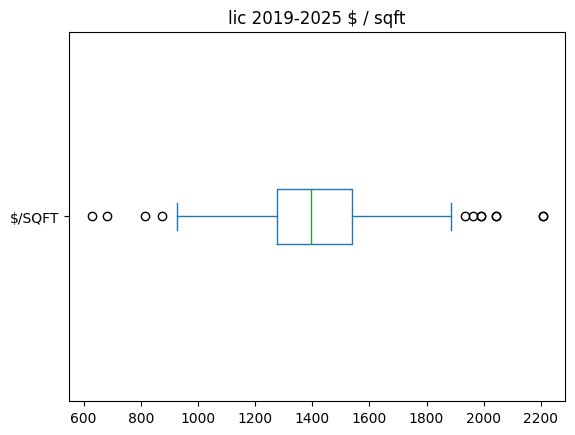

In [ ]:
# 728 sample
# $/sqft median 1396
dflic[(dflic['$/SQFT']>500) & (dflic['$/SQFT']<4000)]['$/SQFT'].plot.box(title='lic 2019-2025 $ / sqft', vert=False)

In [ ]:
dfast['$/SQFT'] = round(dfast['SALE PRICE'] / dfast['SQFT'])
dfast

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,housenum,streetname,aptno,SQFT,$/SQFT
0,11105,2022,261770,2025-05-21,22-54,46TH STREET,301,1.0,261770.0
1,11105,2022,261770,2025-05-16,22-54,46TH STREET,501,1.0,261770.0
2,11106,2022,1155000,2025-05-13,31-27,CRESCENT STREET,2B,981.0,1177.0
3,11102,2020,650000,2025-05-09,23-23,30TH ROAD,4B,716.0,908.0
4,11106,2019,920000,2025-04-30,14-33,31ST AVENUE,2F,760.0,1211.0
...,...,...,...,...,...,...,...,...,...
321,11106,2019,567300,2021-01-14,14-33,31ST AVENUE,3C,494.0,1148.0
322,11106,2019,585983,2021-01-13,14-33,31ST AVENUE,1G,510.0,1149.0
323,11106,2019,840056,2021-01-08,14-33,31ST AVENUE,3F,728.0,1154.0
324,11106,2019,595817,2021-01-07,14-33,31ST AVENUE,3I,560.0,1064.0


In [ ]:
dfast[(dfast['$/SQFT']>500) & (dfast['$/SQFT']<2400)].describe()

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,SQFT,$/SQFT
count,308.000000,308.000000,3.080000e+02,308,308.000000,308.000000
mean,11104.243506,2020.048701,8.101357e+05,2023-03-30 08:52:59.220779264,685.633117,1175.542208
min,11102.000000,2019.000000,3.930000e+05,2020-12-29 00:00:00,387.000000,676.000000
25%,11102.000000,2019.000000,6.250000e+05,2021-12-19 06:00:00,547.500000,1098.750000
50%,11105.000000,2020.000000,7.512100e+05,2023-07-19 00:00:00,636.000000,1177.500000
75%,11106.000000,2021.000000,8.829840e+05,2024-09-16 00:00:00,743.250000,1260.000000
max,11106.000000,2023.000000,2.549000e+06,2025-05-13 00:00:00,1856.000000,1578.000000
std,1.826994,1.121698,3.073309e+05,NaN,220.027253,126.274821


<Axes: title={'center': 'ast 2019-2025 $ / sqft'}>

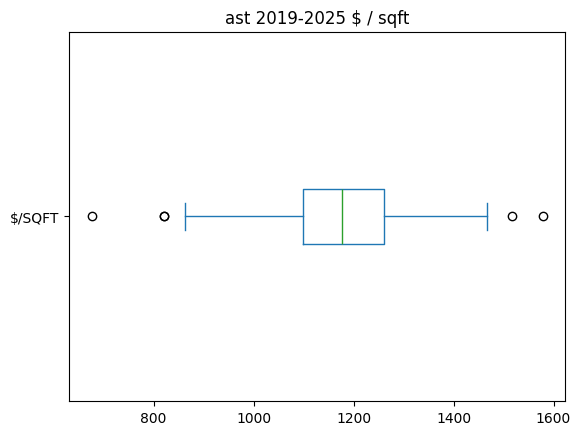

In [ ]:
# 308 sample
# $/sqft median 1177

dfast[(dfast['$/SQFT']>500) & (dfast['$/SQFT']<2400)]['$/SQFT'].plot.box(title='ast 2019-2025 $ / sqft', vert=False)